Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667. Ответим на вопросы:

- Какой набор предложений можно считать лучшим?
- Какие метрики стоит проанализировать для принятия правильного решения и как?

In [101]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as stats

### Посмотрим на данные

In [102]:
AB_mobil_games = pd.read_csv('~/Проект_1_Задание_2.csv', sep = ';')

In [103]:
AB_mobil_games.shape

(404770, 3)

In [104]:
AB_mobil_games.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [105]:
AB_mobil_games.user_id.nunique()

404770

- id пользователей похожи на id в первом задании, уникальных пользоваетелй меньше, но это и логично, тесты проводят не на всех
- количество уникальных пользователей равно количеству строк в датафрейме, а значит по каждому пользователю есть только одна ячейка данных о сумме покупок, то есть, к примеру, метрика - среднее число покупок будет не показательна 

#### Разберёмся, какая из групп тестовая, а какая контрольная:

In [106]:
# посчитаем количество пользователей
AB_mobil_games.groupby('testgroup', as_index=False).agg({'user_id':'count'})

,testgroup,user_id
0,a,202103
1,b,202667


In [107]:
#посчитаем платящих пользователей в каждой из групп
AB_mobil_games.query('testgroup == "a"').query('revenue > 0')['user_id'].count()

1928

In [108]:
#посчитаем платящих пользователей в каждой из групп
AB_mobil_games.query('testgroup == "b"').query('revenue > 0')['user_id'].count()

1805

In [109]:
#посчитаем ARPU в каждой из групп
AB_mobil_games.query('testgroup == "a"')['revenue'].sum() / AB_mobil_games.query('testgroup == "a"')['revenue'].count()

25.413719736965806

In [110]:
#посчитаем ARPU в каждой из групп
AB_mobil_games.query('testgroup == "b"')['revenue'].sum() / AB_mobil_games.query('testgroup == "b"')['revenue'].count()

26.75128659327863

In [111]:
#вычислим 5% у большей группы и вычтем их из её размера
26.75128659327863 - (26.75128659327863 / 100 * 5)

25.413722263614698

- в группе a 1928 платящих пользователей, как в контрольной, в группе b - 1805, как в тестовой, согласно заданию
- в группе a всего 202103 пользователя, как в контрольной, в группе b - 202667, как в тестовой, согласно заданию
- в группе b ARPU составляет 26.7512, что на 5% (с округлением до 4 знака) выше, чем в группе a (25.4137) 
- получается, что a - это контрольная группа, а b - тестовая.

#### переименуем названия групп осмысленно:

In [112]:
AB_mobil_games['testgroup'] = AB_mobil_games['testgroup'].replace({'a':'control', 'b' : 'test'})

## Метрика 1 ARPU
средний доход с пользователя

#### Визуализируем данные по покупкам. Контрольная группа:

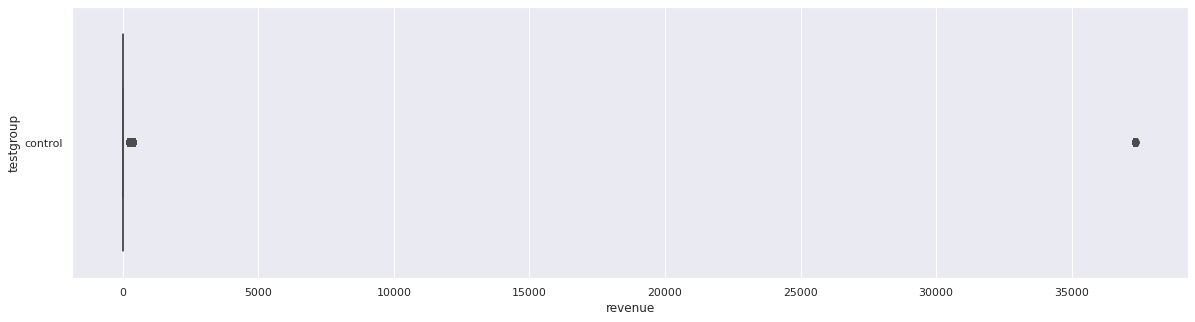

In [146]:
sns.set(rc={'figure.figsize':(20,5)})
sns.boxplot(data=AB_mobil_games.query('testgroup == "control"'), y='testgroup', x='revenue')

#### есть выбросы за 35000:

In [114]:
#смотрим максимальные значения
AB_mobil_games.query('testgroup == "control"').query('revenue > 0').sort_values(by = 'revenue').tail(20)

,user_id,revenue,testgroup
88358,88359,37341,control
321550,321551,37342,control
321014,321015,37344,control
173850,173851,37345,control
360696,360697,37347,control
343212,343213,37349,control
183253,183254,37351,control
356812,356813,37353,control
144685,144686,37355,control
215440,215441,37357,control


In [115]:
AB_mobil_games.query('testgroup == "control"').query('revenue > 0').sort_values(by = 'revenue')['revenue'].describe()
#дорогих покупок меньше 25%

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

- есть много дорогих покупок, но их меньше, чем недорогих, судя по графику
- большинство пользователей - неплатящие

In [117]:
AB_mobil_games.query('testgroup == "control"').query('revenue > 0')['revenue'].quantile(q=0.94)
#примерил подхоящий квантиль для выброса

37295.0

- только около 6% покупок являются сверхдорогими, остальные намного меньше и близки по величине между собой.

#### проверим нормальность распределения

In [118]:
stats.shapiro(AB_mobil_games.query('testgroup == "control"')['revenue'])
#не нормальное

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.008876502513885498, pvalue=0.0)

#### Визуализируем данные по покупкам. Тестовая группа:

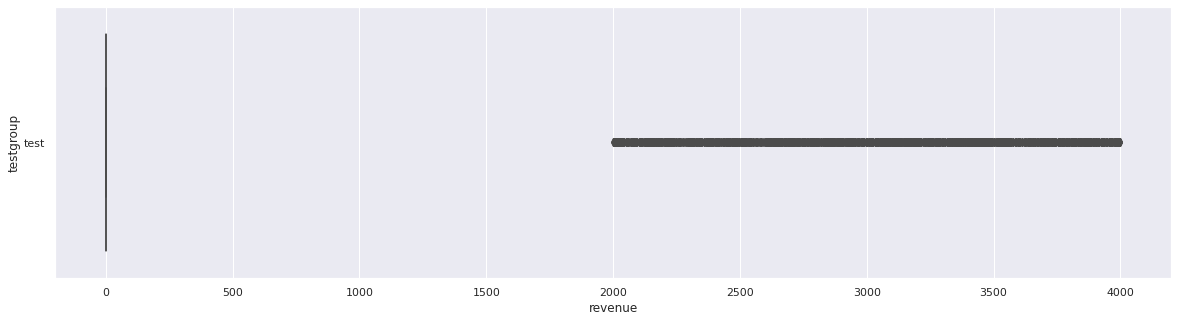

In [147]:
sns.boxplot(data=AB_mobil_games.query('testgroup == "test"'), y='testgroup', x='revenue')

- ситуация более стабильная, пользователи, которые покупают, имеют небольшой разброс в размере покупок - от 2 до 4 тысяч
- также большинство пользователей - неплатящие

#### также проверим на тесте Шапиро-Уилка:

In [120]:
stats.shapiro(AB_mobil_games.query('testgroup == "test"')['revenue'])
#не нормальное распределение

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.06588172912597656, pvalue=0.0)

#### Посмотрим на ARPU у пользователей тестовой и контрольной групп:

In [121]:
AB_mobil_games.query('testgroup == "test"')['revenue'].mean()

26.75128659327863

In [122]:
AB_mobil_games.query('testgroup == "control"')['revenue'].mean()

25.413719736965806

- очень небольшие значения, они очень близки между собой
- У тестовой группы ARPU незначительно выше

#### Формирование гипотез
- H0 - акционный наборы у тестовой и контрольной группы одинаково влияют на средний доход с пользователя 
- H1 - акционные наборы дают различный эффект, в тестовой группе он немого лучше

### Проведение AB-теста
#### Для теста применим метод bootstrap, так как он позволяет работать со средними значениями при ненормальном распределении данных

In [141]:
#создаём пустой список для разницы средних
mean_diff = []

#создаём цикл со случайным взятием из нужного числа выборок
for i in range(10000):
#делаем настройку, что возьмется изначальное количество рядов и что они будут браться с повторением в контрольной группе
    sample_data_control = AB_mobil_games.query('testgroup == "control"').sample(frac=1, replace=True)
    #из получившегося датафрейма будем брать каждый раз среднее
    sample_mean_control = sample_data_control.revenue.mean()
    
    #то же самое повторим для тестовой группы
    sample_data_test = AB_mobil_games.query('testgroup == "test"').sample(frac=1, replace=True)
    sample_mean_test = sample_data_test.revenue.mean()
    
    #соберём каждый раз разницу в средних
    sample_mean_diff = sample_mean_test - sample_mean_control
    mean_diff.append(sample_mean_diff)

In [154]:
pd.Series(mean_diff).quantile([0.025, 0.975])
#разница в средних включает в себя 0

0.025   -2.919549
0.975    5.473951
dtype: float64

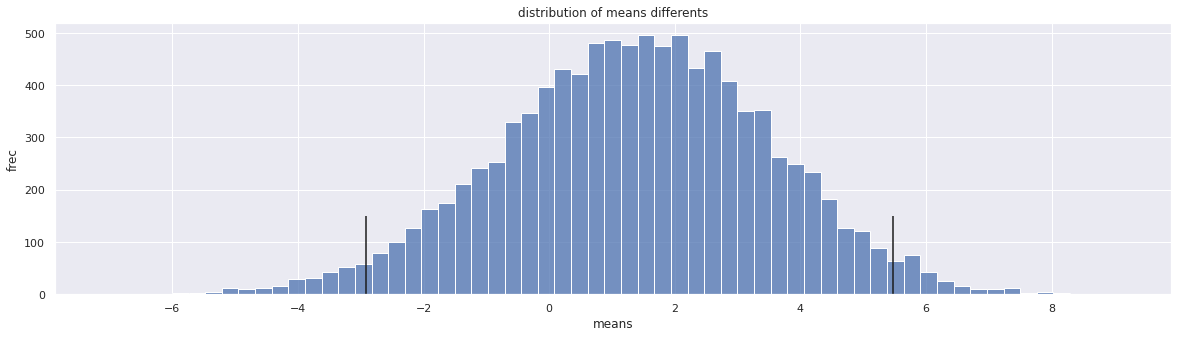

In [157]:
#делаем из списка датафрейм
mean_diff_data = pd.DataFrame(mean_diff)
#определяем 95-процентный доверительный интервал
conf_int = mean_diff_data.quantile([0.025, 0.975])

#строим график с отсечками интервала
sns.histplot(mean_diff, kde=False)

plt.vlines(conf_int,ymin=0,ymax=150,linestyle='-')
plt.xlabel('means')
plt.ylabel('frec')
plt.title("distribution of means differents")

plt.show()

- (!) ARPU для пользователей в группах статистически значимо не отличаются (порог p-value для статистики учитываем как 0,05)

### Метрика 2 ARPPU

средний доход с платящего пользователя

#### Визуализируем данные в обеих группах

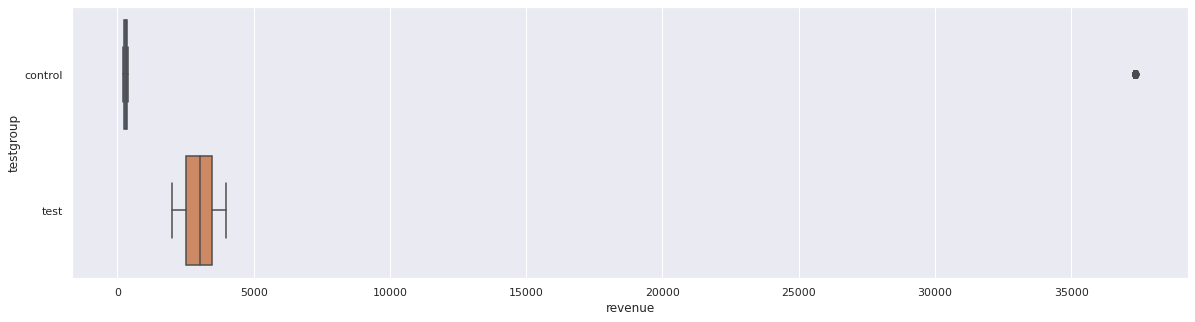

In [149]:
sns.boxplot(data=AB_mobil_games.query('revenue > 0'), y='testgroup', x='revenue')

Мы видим, что платящие пользователи в разных группах ведут себя по-разному. В контрольной группе есть как мелкие покупки, так и значительные.

#### Проверим распределения на нормальность:

In [124]:
stats.shapiro(AB_mobil_games.query('testgroup == "control"').query('revenue > 0')['revenue'])
#у контрольной группы распределение не нормальное

ShapiroResult(statistic=0.2667924761772156, pvalue=0.0)

In [125]:
stats.shapiro(AB_mobil_games.query('testgroup == "test"').query('revenue > 0')['revenue'])
#у тестовой распределение также не нормальное

ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)

#### посмотрим на ARPPU у пользователей тестовой и контрольной групп:

In [126]:
AB_mobil_games.query('testgroup == "control"').query('revenue > 0')['revenue'].mean()

2663.9984439834025

In [127]:
AB_mobil_games.query('testgroup == "test"').query('revenue > 0')['revenue'].mean()

3003.6581717451522

In [128]:
(3003.6581717451522 / 2663.9984439834025) * 100 - 100

12.749997227996346

- отличие заметное
- у тестовой группы ARPPU выше почти на 13%

#### Формирование гипотез
- H0 - акционный наборы у тестовой и контрольной группы одинаково влияют на средний доход с платящего пользователя 
- H1 - акционные наборы дают различный эффект, в тестовой группе он немого лучше

### Проведение AB-теста
также используем bootstrap

In [130]:
#создаём пустой список для разницы средних
mean_diff_ARPPU = []

#создаём цикл со случайным взятием из нужного числа выборок
for i in range(10000):
#делаем настройку, что возьмется изначальное количество рядов и что они будут браться с повторением в контрольной группе
    sample_data_control_ARPPU = AB_mobil_games.query('testgroup == "control"').query('revenue > 0').sample(frac=1, replace=True)
    #из получившегося датафрейма будем брать каждый раз среднее
    sample_mean_control_ARPPU = sample_data_control_ARPPU.revenue.mean()
    
    #то же самое повторим для тестовой группы
    sample_data_test_ARPPU = AB_mobil_games.query('testgroup == "test"').query('revenue > 0').sample(frac=1, replace=True)
    sample_mean_test_ARPPU = sample_data_test_ARPPU.revenue.mean()
    
    #соберём каждый раз разницу в средних
    sample_mean_diff_ARPPU = sample_mean_test_ARPPU - sample_mean_control_ARPPU
    mean_diff_ARPPU.append(sample_mean_diff_ARPPU)

In [150]:
pd.Series(mean_diff_ARPPU).quantile([0.025, 0.975])
#разница в средних включает в себя 0

0.025    -66.617288
0.975    734.648894
dtype: float64

#### визуализируем, построив доверительный интервал значений распределения средних

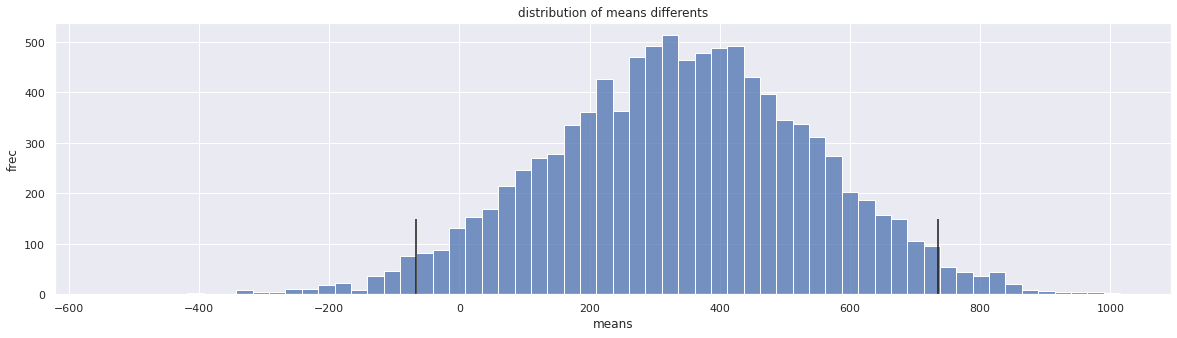

In [156]:
#делаем из списка датафрейм
mean_diff_data_ARPPU = pd.DataFrame(mean_diff_ARPPU)
#определяем 95-процентный доверительный интервал
conf_int = mean_diff_data_ARPPU.quantile([0.025, 0.975])

#строим график с отсечками интервала
sns.histplot(mean_diff_ARPPU, kde=False)

plt.vlines(conf_int,ymin=0,ymax=150,linestyle='-')
plt.xlabel('means')
plt.ylabel('frec')
plt.title("distribution of means differents")

plt.show()

- (!) ARPPU для пользователей в группах статистически значимо не отличаются - нулевое значение (совпадение средних) находится внутри доверительного интервала.
<br><br>
- нулевую гипотезу не отклоняем - акционный наборы у тестовой и контрольной группы одинаково влияют на средний доход с платящего пользователя.

### Метрика 3 CR

конверсия в покупку, или доля платящих пользователей среди всех пользователей

#### Визуализируем эти доли в двух группах, предварительно подготовив датасет:

In [135]:
#создаём новую колонку с булевыми значениями оплаты (нулевая - True, ненулевая - False)
AB_mobil_games['is_zero'] = AB_mobil_games['revenue'] == 0

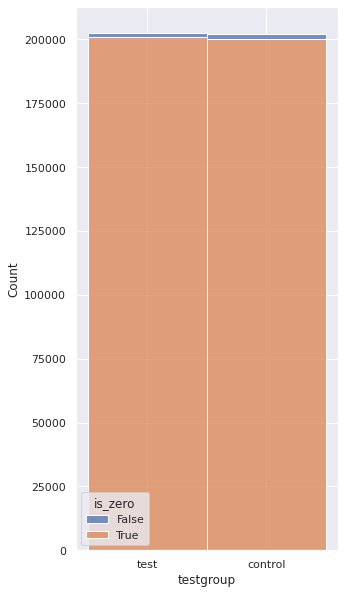

In [136]:
sns.set(rc={'figure.figsize':(4.7,10)})
ax = sns.histplot(AB_mobil_games, x='testgroup', hue = 'is_zero', multiple='stack')

- как и указывалось в условии, в контрольной группе платящих пользователей немного больше, а сама группа немного меньше. Это видно и на графике

#### Посчитаем конверсию в покупку у обеих групп:

In [137]:
AB_mobil_games.query('testgroup == "control"').query('is_zero == False')['is_zero'].count() / \
AB_mobil_games.query('testgroup == "control"').query('is_zero == True')['is_zero'].count()

0.009631572374172599

In [138]:
AB_mobil_games.query('testgroup == "test"').query('is_zero == False')['is_zero'].count() / \
AB_mobil_games.query('testgroup == "test"').query('is_zero == True')['is_zero'].count()

0.00898626917983491

- и так тоже мы видим, что CR у контрольной группы выше

#### Формирование гипотез
- H0 - акционный наборы у тестовой и контрольной группы одинаково влияют желание пользователей заплатить за товар в приложении
- H1 - акционные наборы мотивируют чаще покупать и меняют конверсию пользователя в покупку

### Проведение AB-теста
#### Переменные качественные (да\нет), независимые и их всего две, поэтому проводим тест с помощью Хи-квадрата Пирсона:

In [139]:
from scipy.stats import chi2_contingency

In [140]:
stat, p1, dof, chi = chi2_contingency(pd.crosstab(AB_mobil_games.testgroup, AB_mobil_games.is_zero))
stat, p1 

(4.374729521260405, 0.03647561892312613)

- (!) покупательский интерес для пользователей в группах статистически значимо отличается
<br><br>
- есть все основания отклонить нулевую гипотезу и сказать, что акционные предложения влияют на конверсию в покупку
- в контрольной группе CR статистически значимо выше

### Выводы

- Были проанализрованы две важные для бизнеса метрики - ARPU и ARPPU. Несмотря на то, что значения ARPU и ARPPU по имещимся данным у тестовой группы были выше, статистически значимого различия в доходах с пользователей и доходах с платящих пользователей зафиксировано не было.
<br><br>
- Также был проведён тест по метрике CR (конверсия в покупку). Результаты показали, что покупательский интерес для пользователей в группах статистически значимо отличается. В контрольной группе CR выше.
<br><br>
- Исходя из этого, вариант акционных предложений, предоставленных пользователям в тестовой группе, не повлиял на увеличение среднего дохода с пользователя и на увеличение среднего дохода с платящего пользователя, поэтому масштабировать этот вариант акции на всех пользователей не рекомендуется. Кроме того, CR в покупку у контрольной группы выше. На данный момент лучше оставить те предложения, которые действуют сейчас, которыми и пользовалась контрольная группа.
<br><br>
- Важно учесть, что поведение пользователей различается - если у пользователей контрольной группы есть много мелких покупок, а 6% из них являются сверхдорогими (свыше 35 тыс.), то у тестовой все покупки находятся в диапазоне примерно 2000-4000. При этом количество покупок в целом сопоставимо. 

##### Проект сделан в рамках обучения на Аналитика данных  в Karpov Courses